In [1]:
import tensorflow as tf
import numpy as np
import t3f
tf.set_random_seed(0)
np.random.seed(0)
%matplotlib inline
import matplotlib.pyplot as plt
import metric_util as mt
import data_util as du
from t3f import shapes
from nilearn import image
from skimage.measure import compare_ssim as ssim
from tensorflow.python.util import nest
import copy
from nilearn import plotting
from t3f import ops
import mri_draw_utils as mrd

/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
#sess = tf.InteractiveSession()

In [3]:
def frobenius_norm_tf_squared(x):
    return tf.reduce_sum(x ** 2)

In [4]:
def frobenius_norm_tf(x):
    return tf.reduce_sum(x ** 2) ** 0.5

In [5]:
def relative_error1(x_hat,x_true):
    percent_error = frobenius_norm_tf(x_hat - x_true) / frobenius_norm_tf(x_true)
    return percent_error

In [6]:
def draw(omega, x_true, x_hat, rel_error):
    images_folder = "/work/scratch/tt1"
    ten_ones = np.ones_like(omega)
    x_reconstr1 = mt.reconstruct2(x_hat,ground_truth, omega)
    x_hat_img = mt.reconstruct_image_affine(x_true_org, x_reconstr1)
    x_hat_est = image.index_img(x_hat_img,1)
    
    x_true_org_img = image.index_img(x_true,1)
    x_miss_img = mt.reconstruct_image_affine(x_true_org, x_train)
    x_miss = image.index_img(x_miss_img,1)
    mrd.draw_original_vs_reconstructed_rim(x_true_org_img,x_hat_est, x_miss, "Rim Completion",
                                             rel_error, observed_ratio, coord=None, folder=images_folder)

In [7]:
subject_scan_path = du.get_full_path_subject1()
print "Subject Path: " + str(subject_scan_path)
x_true_org = mt.read_image_abs_path(subject_scan_path)


Subject Path: /work/pl/sch/analysis/data/COBRE001/swaAMAYER+cobre01_63001+M87100944+20110309at135133+RSTpre_V01_R01+CM.nii


In [8]:
observed_ratio = 0.4
x_true_img = np.array(x_true_org.get_data())
mask_indices = (np.random.rand(x_true_img.shape[0],x_true_img.shape[1],x_true_img.shape[2], x_true_img.shape[3]) < observed_ratio).astype('int') 
ten_ones = np.ones_like(mask_indices)
x_train = copy.deepcopy(x_true_img)
x_train[mask_indices==0] = 0.0
x_train[mask_indices == 0] = np.mean(x_train[mask_indices == 1])
#x_train[mask_indices == 0] = np.mean(x_train[mask_indices == 1])

x_init = copy.deepcopy(x_train)
#shape = (1, 53, 63, 63, 1)
#x_init_tf = t3f.random_tensor(shape, tt_rank=63)

ground_truth = copy.deepcopy(x_true_img)

sparse_observation = copy.deepcopy(ground_truth)
sparse_observation[mask_indices==0] = 0.0

In [9]:
ten_ones = np.ones_like(mask_indices)


In [10]:
norm_sparse_observation = np.linalg.norm(sparse_observation)
print norm_sparse_observation

47395410.0


In [11]:
mask_indices_tf = t3f.to_tt_tensor(mask_indices.astype('float32'), max_tt_rank=63)

[1, 53, 1, 1, 1] 0 (1, 53, 53)
[1, 53, 63, 1, 1] 1 (53, 63, 63)
[1, 53, 63, 63, 1] 2 (63, 46, 63)
ranks: [1, 53, 63, 63, 1]


In [12]:
x_miss_img = mt.reconstruct_image_affine(x_true_org, x_train)

In [13]:
x_miss = image.index_img(x_miss_img,1)

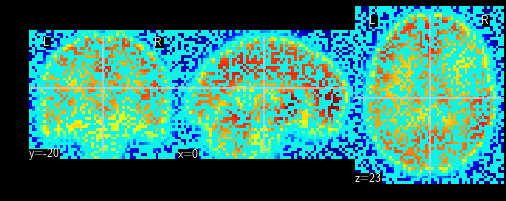

In [14]:
x_miss_image = plotting.plot_epi(x_miss, bg_img=None,black_bg=True, cmap='jet', cut_coords=None) 

In [15]:
images_folder = "/work/scratch/tt1"
mrd.draw_original_vs_reconstructed_rim(image.index_img(x_true_org,1),image.index_img(x_miss_img,1), image.index_img(x_miss_img,1), "Rim Completion",
                                             observed_ratio, observed_ratio, coord=None, folder=images_folder)

('Saving figure', '/work/scratch/tt1/missing_ratio_60.00.png')
Called from mrd


In [16]:
ground_truth_tf = t3f.to_tt_tensor(ground_truth, max_tt_rank=63)

[1, 53, 1, 1, 1] 0 (1, 53, 53)
[1, 53, 63, 1, 1] 1 (53, 63, 63)
[1, 53, 63, 63, 1] 2 (63, 46, 63)
ranks: [1, 53, 63, 63, 1]


In [17]:
A = t3f.get_variable('A', initializer=ground_truth_tf, trainable=False)

In [18]:
ground_truth = tf.get_variable('ground_truth', initializer=ground_truth, trainable=False)
sparsity_mask = tf.get_variable('sparsity_mask', initializer=mask_indices, trainable=False)
sparsity_mask = tf.cast(sparsity_mask,tf.float32)
sparse_observation = ground_truth * sparsity_mask

In [19]:
#sparsity_mask = t3f.get_variable('sparsity_mask', initializer=mask_indices_tf, trainable=False)
#sparsity_mask = t3f.cast(sparsity_mask, tf.float32)
#sparse_observation_tf = t3f.to_tt_tensor(sparse_observation, max_tt_rank=63)
#sparse_observation_tf3 = t3f.get_variable('sparse_observation_tf', initializer=sparse_observation_tf, trainable=False)

In [20]:
x_train_tf = t3f.to_tt_tensor(x_init, max_tt_rank=63)

[1, 53, 1, 1, 1] 0 (1, 53, 53)
[1, 53, 63, 1, 1] 1 (53, 63, 63)
[1, 53, 63, 63, 1] 2 (63, 46, 63)
ranks: [1, 53, 63, 63, 1]


In [21]:
normAOmegavar = tf.get_variable('normAOmega', initializer=norm_sparse_observation, trainable=False)

In [22]:
X = t3f.get_variable('X', initializer=x_train_tf)

In [23]:
print X

A Tensor Train variable of shape (53, 63, 46, 144), TT-ranks: (1, 53, 63, 63, 1)


In [24]:
def train_it_rel_cost(cost_hist, k):
    res = np.abs(cost_hist[k] - cost_hist[k-1])/np.abs(cost_hist[k])
    return res

In [25]:
# Algorithm
#grad_full = (t3f.full(X)*t3f.full(sparse_observation_tf3) - t3f.full(sparse_observation_tf3))
grad_full = sparsity_mask * t3f.full(X) - sparse_observation
grad_t3f = t3f.to_tt_tensor(grad_full, max_tt_rank=63)

loss = 0.5 * t3f.frobenius_norm_squared(grad_t3f)
gradnorm_omega = t3f.frobenius_norm(grad_t3f)/(normAOmegavar)

riemannian_grad = t3f.riemannian.project(grad_t3f, X)
#riemannian_grad_norm = t3f.flat_inner(riemannian_grad, riemannian_grad)



#rel_error1 = relative_error1(t3f.full(X), t3f.full(sparse_observation))




[1, 53, 1, 1, 1] 0 (1, 53, 53)
[1, 53, 63, 1, 1] 1 (53, 63, 63)
[1, 53, 63, 63, 1] 2 (63, 46, 63)
ranks: [1, 53, 63, 63, 1]


In [26]:
eps = 1e-3
epsilon_train=1e-5

In [27]:
print grad_full

Tensor("sub:0", shape=(53, 63, 46, 144), dtype=float32)


In [28]:
print grad_t3f

A Tensor Train of shape (53, 63, 46, 144), TT-ranks: (1, 53, 63, 63, 1)


In [29]:
print eps

0.001


In [30]:
alpha = 0.3
train_step = t3f.assign(X, t3f.round(X - alpha * riemannian_grad, max_tt_rank=63))

In [31]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [32]:
log = []
train_loss_hist = []
#for i in range(1000):
gradnorm_val = sess.run([gradnorm_omega])
print gradnorm_val

[0.24615465]


In [33]:


i = 0
while gradnorm_val > eps:   
#for k in range(50):
    i = i + 1
    F_v, gradnorm_val, _ = sess.run([loss, gradnorm_omega, train_step.op])
    
    train_loss_hist.append(gradnorm_val)
    if i > 1:
        diff_train = np.abs(train_loss_hist[i - 1] - train_loss_hist[i-2])/np.abs(train_loss_hist[i-1])
        print (F_v, i, gradnorm_val, diff_train)
        if diff_train <= epsilon_train:
            print "Breaking after " + str(i) + " iterations"
            break
    log.append(F_v)

(52739808000000.0, 2, 0.21669456, 0.13595213)
(40893613000000.0, 3, 0.19081235, 0.13564225)
(31727777000000.0, 4, 0.16807324, 0.13529289)
(24635022000000.0, 5, 0.14810005, 0.13486281)
(19144360000000.0, 6, 0.1305567, 0.13437338)
(14894175000000.0, 7, 0.11515611, 0.13373668)
(11603681000000.0, 8, 0.1016428, 0.13294895)
(9056476000000.0, 9, 0.08979628, 0.13192663)
(7098816000000.0, 10, 0.07950083, 0.12950116)
(5610302600000.0, 11, 0.070675984, 0.12486345)
(4461232000000.0, 12, 0.06302403, 0.12141329)
(3564746300000.0, 13, 0.056336913, 0.11869866)
(2859975800000.0, 14, 0.05046147, 0.116434224)
(2304933400000.0, 15, 0.045301013, 0.113914855)
(1864894600000.0, 16, 0.040747963, 0.11173687)
(1514491300000.0, 17, 0.036720797, 0.10966988)
(1234820900000.0, 18, 0.03315742, 0.10746849)
(1010793900000.0, 19, 0.029999224, 0.105275884)
(830873140000.0, 20, 0.027198572, 0.102970585)
(686114000000.0, 21, 0.024715925, 0.10044727)
(568603840000.0, 22, 0.022500057, 0.098482765)
(473688640000.0, 23, 0.020

(1946558500.0, 177, 0.0013164745, 7.834863e-05)
(1944567300.0, 178, 0.001315801, 0.0005118271)
(1946311200.0, 179, 0.0013163909, 0.00044810126)
(1943133400.0, 180, 0.0013153158, 0.0008173668)
(1945078700.0, 181, 0.001315974, 0.00050017115)
(1945883600.0, 182, 0.0013162463, 0.0002068727)
(1942500400.0, 183, 0.0013151015, 0.0008705246)
(1943076700.0, 184, 0.0013152966, 0.00014834074)
(1943161900.0, 185, 0.0013153255, 2.19497e-05)
(1946108200.0, 186, 0.0013163222, 0.0007572219)
(1943593700.0, 187, 0.0013154716, 0.00064664776)
(1941832600.0, 188, 0.0013148754, 0.00045339874)
(1943650700.0, 189, 0.0013154909, 0.0004678769)
(1945254800.0, 190, 0.0013160337, 0.0004123969)
(1944255200.0, 191, 0.0013156955, 0.0002570401)
(1943356500.0, 192, 0.0013153913, 0.00023125684)
(1943293700.0, 193, 0.0013153701, 1.61077e-05)
(1945924400.0, 194, 0.0013162601, 0.00067615445)
(1941835400.0, 195, 0.0013148765, 0.0010522632)
(1942918900.0, 196, 0.0013152432, 0.00027881403)
(1942940000.0, 197, 0.0013152504, 5.

In [34]:
print X

A Tensor Train variable of shape (53, 63, 46, 144), TT-ranks: (1, 53, 63, 63, 1)


In [35]:
estimated_val = sess.run(t3f.full(X))

In [36]:
ground_truth_val = sess.run(ground_truth)


In [37]:
x_reconstr = mt.reconstruct(estimated_val,ground_truth_val, ten_ones, mask_indices)


In [38]:
def relative_error(x_hat,x_true):
    percent_error = np.linalg.norm(x_hat - x_true) / np.linalg.norm(x_true)
    return percent_error

In [39]:
rel_error = relative_error(estimated_val,ground_truth_val)

In [40]:
print rel_error

0.0038975324


In [41]:
rel_error_rec = relative_error(x_reconstr,ground_truth_val)

In [42]:
rel_error_rec

0.0030929133780565853

In [43]:
x_miss_img = mt.reconstruct_image_affine(x_true_org, x_train)

In [44]:
x_miss = image.index_img(x_miss_img,1)

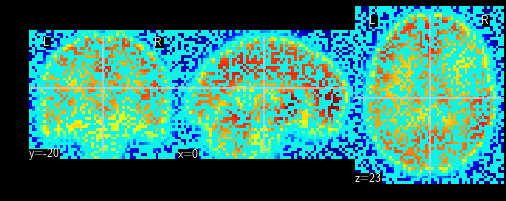

In [45]:
x_miss_image = plotting.plot_epi(x_miss, bg_img=None,black_bg=True, cmap='jet', cut_coords=None) 

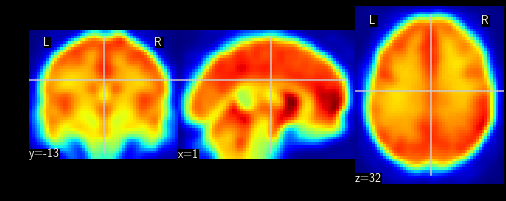

In [46]:
x_hat_img = mt.reconstruct_image_affine(x_true_org, x_reconstr)
x_hat = image.index_img(x_hat_img,1)
recovered_image = plotting.plot_epi(x_hat, bg_img=None,black_bg=True, cmap='jet', cut_coords=None)

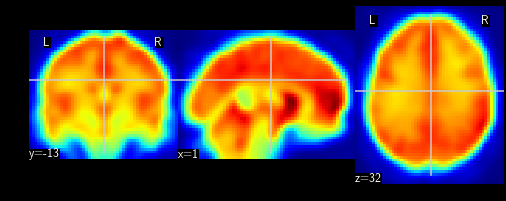

In [47]:
x_true_org_img = image.index_img(x_true_org,1)
org_image = plotting.plot_epi(x_true_org_img, bg_img=None,black_bg=True, cmap='jet', cut_coords=None)

In [48]:
images_folder = "/work/scratch/tt1/1"
mrd.draw_original_vs_reconstructed_rim(image.index_img(x_true_org,1),x_hat, image.index_img(x_miss_img,1), "Rim Completion",
                                             observed_ratio, observed_ratio, coord=None, folder=images_folder)

('Saving figure', '/work/scratch/tt1/1/missing_ratio_60.00.png')
Called from mrd


In [49]:
estimated_val_img = mt.reconstruct_image_affine(x_true_org, estimated_val)

In [50]:
estimated_val_hat = image.index_img(estimated_val_img,1)

In [51]:
images_folder = "/work/scratch/tt1/2"
mrd.draw_original_vs_reconstructed_rim(image.index_img(x_true_org,1),estimated_val_hat,image.index_img(x_miss_img,1), "Rim Completion2",
                                             observed_ratio, observed_ratio, coord=None, folder=images_folder)

('Saving figure', '/work/scratch/tt1/2/missing_ratio_60.00.png')
Called from mrd
